In [46]:
import numpy as np
import time
import mmap
import matplotlib.pyplot as plt
np.random.seed(42)

In [47]:
def adj_d(a, b, adj): return adj[a][b]


def euc_2d(a, b): return np.linalg.norm(x=np.asarray(a)-np.asarray(b), ord=2)


def att(a, b):
    d = euc_2d(a, b)
    d_ = float(int(d))

    if d_ < d:
        return d_ + 1.
    else:
        return d_

def fill_lower_diag(a):
    n = int(np.sqrt(len(a)*2))+1
    mask = np.tri(n,dtype=bool, k=-1)
    out = np.zeros((n,n),dtype=int)
    out[mask] = a
    return out

def parse_adjecency(path):
    edge_type = None
    adj = []
    position = 0
    with open(path, 'rb') as f:
        m = mmap.mmap(f.fileno(), 0, mmap.MAP_PRIVATE, mmap.PROT_READ)
        position = m.find(str.encode('EDGE_WEIGHT_TYPE'))

    with open(path, 'r') as f:
        f.seek(position, 0)
        line = f.readline().replace('\n','')
        edge_type = line.split()[-1]
        if edge_type == "EUC_2D":
            edge_type = euc_2d
        if edge_type == "ATT":
            edge_type = att
        if edge_type == "EXPLICIT":
            edge_type = adj_d
    if edge_type == adj_d:
        diag_form = False
        with open(path, 'rb') as f:
            m = mmap.mmap(f.fileno(), 0, mmap.MAP_PRIVATE, mmap.PROT_READ)
            position = m.find(str.encode('EDGE_WEIGHT_FORMAT'))
        with open(path, 'r') as f:
            f.seek(position, 0)
            diag_form = f.readline().split()[-1] == "LOWER_DIAG_ROW"
        with open(path, 'rb') as f:
            m = mmap.mmap(f.fileno(), 0, mmap.MAP_PRIVATE, mmap.PROT_READ)
            position = m.find(str.encode('EDGE_WEIGHT_SECTION'))
        with open(path, 'r') as f:
            f.seek(position, 0)
            for line in f:
                line = line.replace("\n", "")
                if line == "EDGE_WEIGHT_SECTION":
                    continue
                if line == "EOF" or line == "DISPLAY_DATA_SECTION":
                    break
                adj.append([float(i) for i in line.split()])

        if diag_form:
            nonzero_adj = []
            for i in adj:
                nonzero_adj.extend([j for j in i if j != 0])
            
            lower = fill_lower_diag(nonzero_adj)
            upper = lower.T
            adj = upper+lower

    elif edge_type is not None:
        with open(path, 'rb') as f:
            m = mmap.mmap(f.fileno(), 0, mmap.MAP_PRIVATE, mmap.PROT_READ)
            position = m.find(str.encode('NODE_COORD_SECTION'))
        with open(path, 'r') as f:
            f.seek(position, 0)
            for line in f:
                line = line.replace("\n", "")
                if line == "NODE_COORD_SECTION":
                    continue
                if line == "EOF":
                    break
                data = line.split()
                adj.append([int(data[0]), float(data[1]), float(data[2])])

    return edge_type, adj

In [48]:
def make_genes(idxs, n):
    def make_gene(): return np.random.permutation(idxs)
    return [make_gene().tolist() for i in range(0, n)]


def ord_crossover(a, b, window=5, verbose=False):

    p1 = np.random.randint(0, len(a))

    p2 = (p1 + window) % len(a)

    l = len(a)

    if p2 < p1:
        p1, p2 = p2, p1

    o1 = a[p1:p2]
    o2 = b[p1:p2]

    if verbose:
        print(o1, o2)

    a = [e for e in a[p2:]+a[:p2] if e not in o2]
    b = [e for e in b[p2:]+b[:p2] if e not in o1]

    if verbose:
        print(b[l-p2:]+["o1"]+b[:l-p2], a[l-p2:]+["o2"]+a[:l-p2])

    o1 = b[l-p2:]+o1+b[:l-p2]
    o2 = a[l-p2:]+o2+a[:l-p2]

    return o1, o2


def disp_mutation(a, window=5, p=0.01, verbose=False):
    bit_mask = np.random.choice(a=[True, False], size=len(a), p=[p, 1-p])

    for i, mut in enumerate(bit_mask):
        if mut:
            p1 = i
            p2 = (p1 + window) % len(a)

            if p2 < p1:
                p1, p2 = p2, p1

            if verbose:
                print(a[p1: p2])

            a__ = [e for e in a if e not in a[p1: p2]]
            p3 = np.random.randint(0, len(a__))

            a = a__[:p3]+a[p1: p2]+a__[p3:]

    return a


def fitness(gene, adj, func):
    if func == adj_d:
        return sum([func(gene[i]-1, gene[(i+1)%len(gene)]-1, adj) for i in range(0, len(gene))])
    else:
        return sum([func(adj[gene[i]-1], adj[gene[(i+1)%len(gene)]-1]) for i in range(0, len(gene))])

In [49]:
class EvolutionTSP():
    def __init__(self, path, population_n, cross=ord_crossover, mutation=disp_mutation):
        self.cross = cross
        self.mutation = mutation
        self.fit_type, self.adj = parse_adjecency(path)

        self.population = make_genes([i for i in range(1,len(self.adj)+1)], population_n)
        pass
    
    def get_best(self):
        chromo = sorted(self.population, key=lambda x : fitness(x, self.adj, self.fit_type))[0]
        score = fitness(chromo, self.adj, self.fit_type)
        return chromo, score

    def __call__(self):
        self.population = sorted(self.population, key=lambda x : fitness(x, self.adj, self.fit_type))
        l = len(self.population)
        l_4 = int(l/4)

        next_generation = []

        for i in range(0, int(l/2)):
            g1 = np.random.choice(a=[0, 1, 2, 3], p=[0.5, 0.3, 0.15, 0.05])
            g2 = np.random.choice(a=[0, 1, 2, 3], p=[0.5, 0.3, 0.15, 0.05])
            p1 = g1 + np.random.randint(0, l_4)
            p2 = g2 + np.random.randint(0, l_4)
            o1, o2 = self.cross(self.population[p1], self.population[p2])
            next_generation.append(self.mutation(o1))
            next_generation.append(self.mutation(o2))

        self.population = next_generation

In [50]:
def train_evo(path, population_n, train_time, track_convergence=False):
    if track_convergence:
        hist = []
    tsp=EvolutionTSP(path=path, population_n=population_n)
    start = time.time()
    gens = 0
    while(time.time()-start < train_time):
        tsp()
        if track_convergence:
            hist.append(tsp.get_best()[-1])
        gens += 1
    idxs, score = tsp.get_best()
    if track_convergence:
        return idxs, score, gens, hist
    else:
        return idxs, score, gens


In [51]:
from os import walk
folder = '../Lab3/tsp_samples/'
files_list = []
for (dirpath, dirnames, filenames) in walk(folder):
    files_list.extend(filenames)
    break

In [52]:
convergences = {}

for i, sample in enumerate(files_list):
    print(f'sample №{i+1} -- {sample}')
    idxs, score, generations, convergences[sample] = train_evo("../Lab3/tsp_samples/"+sample, 32, 3600, track_convergence=True)
    print('----------------------')
    print(f'genetic alg:')
    print(f'cycle indexes: {idxs}')
    print(f'score: {score}')
    print(f'total generations: {generations}')
    print('----------------------\n')
        

sample №1 -- bays29.tsp
----------------------
genetic alg:
cycle indexes: [2, 5, 6, 12, 9, 26, 29, 3, 20, 10, 4, 15, 14, 18, 17, 22, 11, 7, 25, 19, 13, 16, 8, 23, 24, 27, 28, 1, 21]
score: 2309.0
total generations: 2355
----------------------

sample №2 -- att48.tsp
----------------------
genetic alg:
cycle indexes: [37, 6, 44, 46, 9, 8, 31, 7, 11, 47, 23, 40, 1, 22, 41, 16, 3, 13, 25, 14, 48, 29, 42, 5, 21, 39, 32, 24, 10, 35, 45, 26, 4, 2, 34, 15, 12, 20, 33, 38, 36, 28, 18, 30, 17, 27, 43, 19]
score: 50311.0
total generations: 264
----------------------

sample №3 -- ch150.tsp
----------------------
genetic alg:
cycle indexes: [27, 129, 45, 49, 82, 103, 95, 46, 134, 142, 35, 33, 106, 9, 28, 15, 14, 112, 16, 59, 79, 125, 4, 13, 25, 135, 20, 120, 118, 108, 29, 86, 70, 137, 2, 57, 117, 144, 140, 36, 12, 39, 32, 51, 6, 99, 76, 30, 87, 21, 80, 19, 92, 18, 97, 143, 1, 100, 96, 98, 56, 53, 40, 114, 5, 85, 141, 132, 127, 38, 66, 148, 11, 130, 17, 83, 73, 68, 74, 128, 88, 91, 136, 133, 24, 

In [53]:
def cummin(a):
    return [min(a[0:i]) for i in range(1, len(a))]

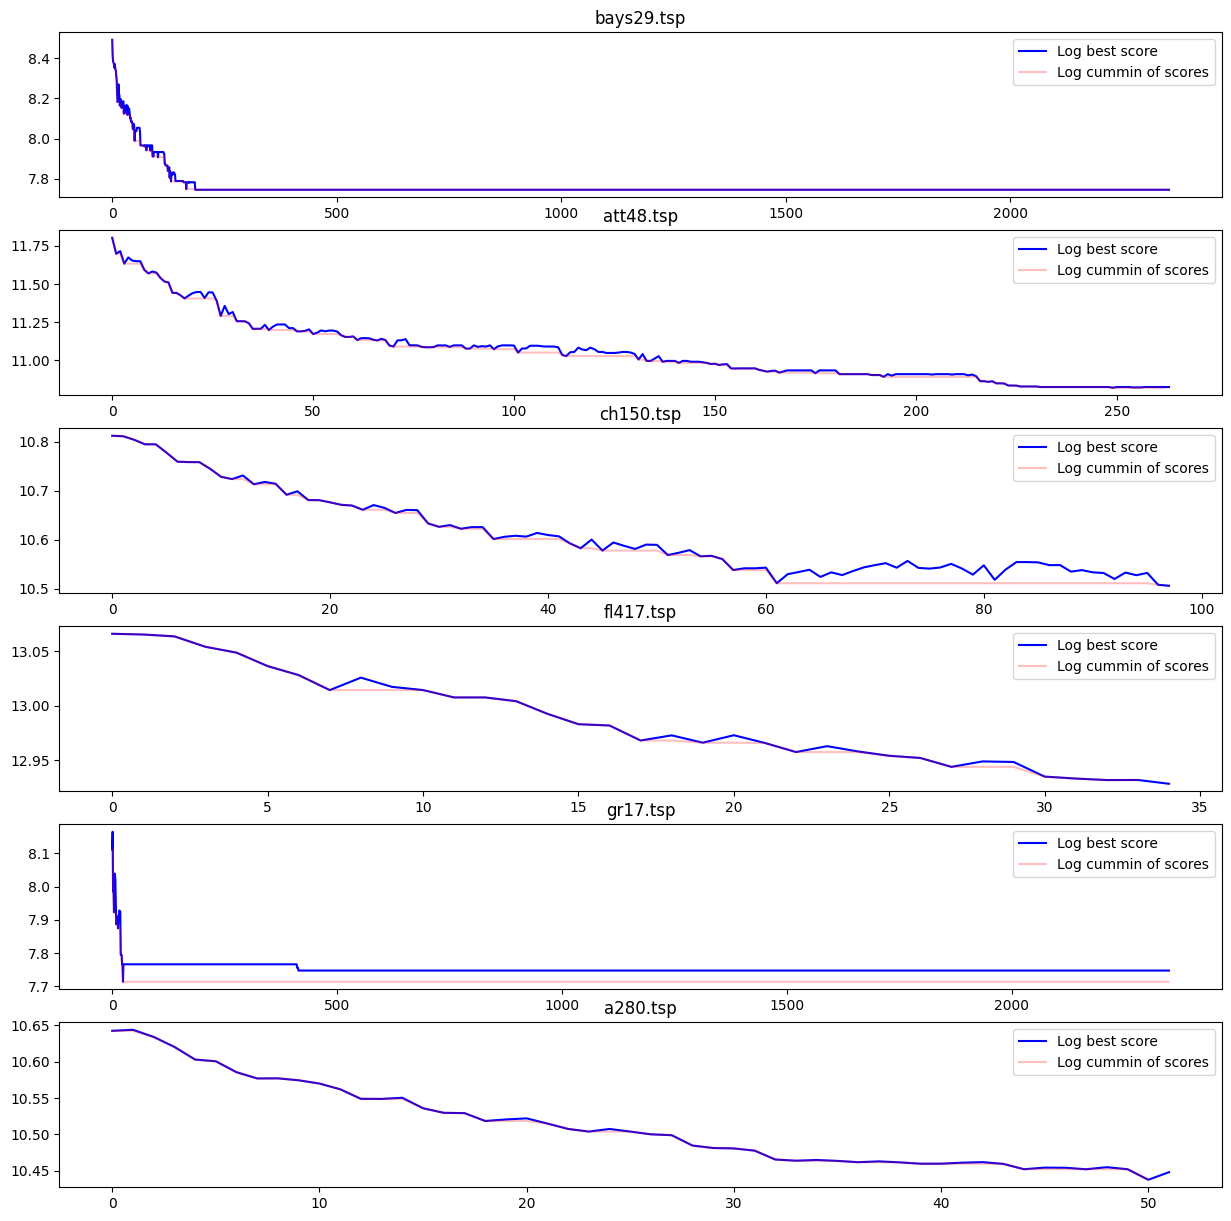

In [54]:
fig, axs = plt.subplots(6, 1, figsize=(15, 15))

for i, (k, v) in enumerate(convergences.items()):
    axs[i].plot(range(0,len(v)), np.log(v), "b", label='Log best score')
    axs[i].plot(range(0,len(v)-1), np.log(cummin(v)), 'r', alpha=0.25, label='Log cummin of scores')
    axs[i].set_title(k)
    axs[i].legend()